### Etymology Prefix Suffix Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import re
from kneed import KneeLocator
from pathlib import Path
import shutil

In [2]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "German"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# pre-suffix select
prefix = True  # True, False  word is prefix  example: prefix = True and suffix = False for Turkish word
suffix = False # True, False  word is suffix

# native word select
word_analysis = False  # True, False  Not: True for native word analysis, False for etymological word analysis
word_num = 28

In [3]:
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)

In [4]:
def detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False):
    '''
    default parameter:\n
    detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False)\n
    detect_prefix_suffix_word(df, "word", ["abacus","aba","su"], prefix=True, suffix=True)\n
    df is dataframe. Each word of word_ety_list search in df_column according to prefix_word and suffix_word condition.\n
    prefix_word and suffix_word are not extention. they represents location of word of word_ety_list (word before or after)
    '''    
    df_ety_prefix_suffix_word_result = pd.DataFrame()
    for i in word_ety_list:
        # suffix result
        if suffix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"{i}(?:$)", na=True)]  # string+ext=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass
        # prefix result
        if prefix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"(?:^){i}", na=True)]  # ext+string=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass    
        
    #df_ety_suffix_word_result = df_word_result.sort_values(by="frequency", ascending=False)
    df_ety_prefix_suffix_word_result.drop_duplicates(inplace=True)
    df_ety_prefix_suffix_word_result.reset_index(drop=True, inplace=True)

    return df_ety_prefix_suffix_word_result 

In [5]:
def exract_prefix_suffix(df, source_column, target_column):
    '''
    exract_prefix_suffix(df, source_column, target_column):\n
    exract_prefix_suffix(df, "word_pair", "word"):\n
    df is dataframe. word of source_column search in target_column\n
    and exract prefix or suffix. 
    '''
    for i in range(len(df)):
        source_word = df.loc[i,f"{source_column}"]
        target_word = df.loc[i,f"{target_column}"]
        try:
            search_loc = re.search(fr"{source_word}", target_word, re.UNICODE|re.IGNORECASE)
            search_loc_start = search_loc.span()[0]
            search_loc_end = search_loc.span()[1]
            if search_loc_start > 0:
                var1= target_word[0:search_loc_start]
                prefix_suffix = f"{var1}+"
                df.loc[i,"prefix_suffix"] = prefix_suffix                
            else:
                var2 = target_word[search_loc_end:]
                prefix_suffix = f"+{var2}" 
                df.loc[i,"prefix_suffix"] = prefix_suffix 
        except:
            pass
    return df

##### Prefix Suffix All

In [6]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
...,...,...
988212,karneleme,5
988213,karnaya,5
988214,dörtlümüzün,5
988215,karnavalınız,5


In [7]:
if word_analysis:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
    df_pair = df_pair.head(word_num)
    df_pair.rename(columns={"word":"dict_entry_main"}, inplace=True)
else:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}/{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Vocabulary.xlsx")
df_pair

,dict_entry_main,german_word
0,enteresan,interessant
1,süper,super
2,boks,boxen
3,komik,comic
4,aktif,aktiv
...,...,...
1454,zebra,zebra
1455,zikzak,zickzack
1456,zombi,zombie
1457,zooloji,zoologie


In [8]:
word_ety_list = df_pair["dict_entry_main"].values.tolist()
#word_ety_list

In [9]:
df_prefix_suffix_word = detect_prefix_suffix_word(df_word_all, "word", word_ety_list, prefix_word=prefix, suffix_word=suffix)
df_prefix_suffix_word

,search_word,word,frequency
0,enteresan,enteresan,6562
1,enteresan,enteresandı,151
2,enteresan,enteresanmış,88
3,enteresan,enteresandır,43
4,enteresan,enteresansın,15
...,...,...,...
70905,zum,zumanın,6
70906,zum,zumanityi,5
70907,zum,zumbidir,5
70908,zum,zumluyor,5


In [10]:
df_prefix_suffix = exract_prefix_suffix(df_prefix_suffix_word, "search_word", "word")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,enteresan,enteresan,6562,+
1,enteresan,enteresandı,151,+dı
2,enteresan,enteresanmış,88,+mış
3,enteresan,enteresandır,43,+dır
4,enteresan,enteresansın,15,+sın
...,...,...,...,...
70905,zum,zumanın,6,+anın
70906,zum,zumanityi,5,+anityi
70907,zum,zumbidir,5,+bidir
70908,zum,zumluyor,5,+luyor


In [11]:
df_prefix_suffix.search_word.nunique()

1441

In [12]:
df_prefix_suffix.word.nunique()

66103

In [13]:
if word_analysis:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx", index=False)
else:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx", index=False)

##### Select From Length

In [14]:
if word_analysis:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_All.xlsx")
else:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,enteresan,enteresan,6562,+
1,enteresan,enteresandı,151,+dı
2,enteresan,enteresanmış,88,+mış
3,enteresan,enteresandır,43,+dır
4,enteresan,enteresansın,15,+sın
...,...,...,...,...
70905,zum,zumanın,6,+anın
70906,zum,zumanityi,5,+anityi
70907,zum,zumbidir,5,+bidir
70908,zum,zumluyor,5,+luyor


In [15]:
df_prefix_suffix["prefix_suffix_len"] = df_prefix_suffix["prefix_suffix"].apply(lambda x: (len(x)-1))
df_prefix_suffix

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,enteresan,enteresan,6562,+,0
1,enteresan,enteresandı,151,+dı,2
2,enteresan,enteresanmış,88,+mış,3
3,enteresan,enteresandır,43,+dır,3
4,enteresan,enteresansın,15,+sın,3
...,...,...,...,...,...
70905,zum,zumanın,6,+anın,4
70906,zum,zumanityi,5,+anityi,6
70907,zum,zumbidir,5,+bidir,5
70908,zum,zumluyor,5,+luyor,5


In [16]:
prefix_suffix_mean = int(round(df_prefix_suffix["prefix_suffix_len"].mean(),0))
prefix_suffix_mean

5

In [17]:
df_prefix_suffix_select = df_prefix_suffix[df_prefix_suffix["prefix_suffix"].str.len() <= prefix_suffix_mean]
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,enteresan,enteresan,6562,+,0
1,enteresan,enteresandı,151,+dı,2
2,enteresan,enteresanmış,88,+mış,3
3,enteresan,enteresandır,43,+dır,3
4,enteresan,enteresansın,15,+sın,3
...,...,...,...,...,...
70898,zum,zumda,8,+da,2
70900,zum,zumlama,8,+lama,4
70901,zum,zumwalt,7,+walt,4
70902,zum,zumi,6,+i,1


In [18]:
if word_analysis:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx", index=False)
else:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx", index=False)

##### Select With Prefix Suffix

In [19]:
if word_analysis:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Select.xlsx")
else:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx")
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,enteresan,enteresan,6562,+,0
1,enteresan,enteresandı,151,+dı,2
2,enteresan,enteresanmış,88,+mış,3
3,enteresan,enteresandır,43,+dır,3
4,enteresan,enteresansın,15,+sın,3
...,...,...,...,...,...
30759,zum,zumda,8,+da,2
30760,zum,zumlama,8,+lama,4
30761,zum,zumwalt,7,+walt,4
30762,zum,zumi,6,+i,1


In [20]:
df_prefix_suffix_freq = df_prefix_suffix_select[["prefix_suffix"]].value_counts().reset_index()
df_prefix_suffix_freq.rename(columns={0:"frequency"}, inplace=True)
df_prefix_suffix_freq

,prefix_suffix,frequency
0,+,1428
1,+ler,492
2,+lar,454
3,+leri,451
4,+e,430
...,...,...
4426,+kalk,1
4427,+kam,1
4428,+kamı,1
4429,+kani,1


In [21]:
prefix_suffix_freq_sum = df_prefix_suffix_freq.loc[:,"frequency"].sum()
prefix_suffix_freq_sum

30764

In [22]:
df_prefix_suffix_freq["ratio"] = round(((df_prefix_suffix_freq.loc[:,"frequency"]/prefix_suffix_freq_sum)*100),7)
df_prefix_suffix_freq


,prefix_suffix,frequency,ratio
0,+,1428,4.641789
1,+ler,492,1.599272
2,+lar,454,1.475751
3,+leri,451,1.465999
4,+e,430,1.397738
...,...,...,...
4426,+kalk,1,0.003251
4427,+kam,1,0.003251
4428,+kamı,1,0.003251
4429,+kani,1,0.003251


In [23]:
df_prefix_suffix_freq["cumul_ratio"] = np.cumsum(df_prefix_suffix_freq["ratio"])
df_prefix_suffix_freq

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,1428,4.641789,4.641789
1,+ler,492,1.599272,6.241061
2,+lar,454,1.475751,7.716812
3,+leri,451,1.465999,9.182811
4,+e,430,1.397738,10.580549
...,...,...,...,...
4426,+kalk,1,0.003251,99.987138
4427,+kam,1,0.003251,99.990389
4428,+kamı,1,0.003251,99.993639
4429,+kani,1,0.003251,99.996890


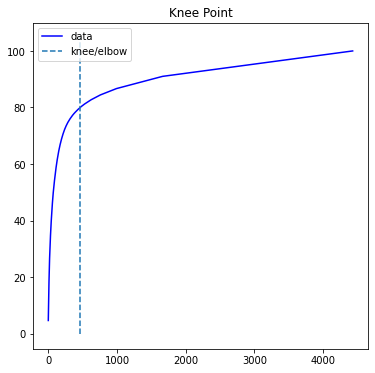

In [24]:
prefix_suffix_kneedle = KneeLocator(x=df_prefix_suffix_freq.cumul_ratio.index, y=df_prefix_suffix_freq.cumul_ratio, S=1.0, curve="concave", direction="increasing")
prefix_suffix_kneedle.plot_knee()

In [25]:
knee_point_prefix_suffix = round(prefix_suffix_kneedle.knee_y)
knee_point_prefix_suffix

80

In [26]:
df_prefix_suffix_knee = df_prefix_suffix_freq[df_prefix_suffix_freq.cumul_ratio <= knee_point_prefix_suffix]
df_prefix_suffix_knee

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,1428,4.641789,4.641789
1,+ler,492,1.599272,6.241061
2,+lar,454,1.475751,7.716812
3,+leri,451,1.465999,9.182811
4,+e,430,1.397738,10.580549
...,...,...,...,...
458,+adır,7,0.022754,79.888832
459,+ham,7,0.022754,79.911586
460,+sina,7,0.022754,79.934340
461,+hane,7,0.022754,79.957093


In [27]:
prefix_suffix_list = df_prefix_suffix_knee["prefix_suffix"].to_list()

In [28]:
disable_prefix_suffix_list = ["+anityi","+bidir","+workun","+düktörlere","+rysin","+ein","+ei","+x","+ren","+hul"]

In [29]:
set_prefix_suffix = set(prefix_suffix_list)
set_disable_prefix_suffix = set(disable_prefix_suffix_list)

In [30]:
prefix_suffix_custom_list = list(set_prefix_suffix.difference(set_disable_prefix_suffix))

In [31]:
df_prefix_suffix_custom = pd.DataFrame()
for i in prefix_suffix_custom_list:
    df_var = df_prefix_suffix[df_prefix_suffix["prefix_suffix"] == f"{i}"]
    df_prefix_suffix_custom = pd.concat([df_prefix_suffix_custom, df_var], axis=0)
df_prefix_suffix_custom.sort_values(by="word", inplace=True)
df_prefix_suffix_custom.reset_index(drop=True, inplace=True)
df_prefix_suffix_custom

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,abaküs,abaküs,158,+,0
1,abaküs,abaküse,6,+e,1
2,abaküs,abaküsle,10,+le,2
3,abaküs,abaküsler,7,+ler,3
4,abaküs,abaküsü,20,+ü,1
...,...,...,...,...,...
24577,şırınga,şırıngasını,14,+sını,4
24578,şırınga,şırıngaya,160,+ya,2
24579,şırınga,şırıngaydı,6,+ydı,3
24580,şırınga,şırıngayla,249,+yla,3


In [32]:
df_frequency_mean = df_prefix_suffix_custom.groupby(["search_word"])[["frequency"]].mean()
df_frequency_mean.reset_index(inplace=True)
df_frequency_mean.rename(columns={"frequency":"frequency_mean"}, inplace=True)
df_frequency_mean

,search_word,frequency_mean
0,abaküs,32.714286
1,abluka,148.750000
2,absorbe,232.500000
3,absürt,140.333333
4,adaptasyon,138.800000
...,...,...
1436,şok,1393.222222
1437,şoke,2072.000000
1438,şov,1057.810811
1439,şut,203.238095


In [33]:
df_prefix_suffix_freq_mean = pd.merge(df_prefix_suffix_custom, df_frequency_mean, how="inner", on="search_word")
df_prefix_suffix_freq_mean

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,abaküs,abaküs,158,+,0,32.714286
1,abaküs,abaküse,6,+e,1,32.714286
2,abaküs,abaküsle,10,+le,2,32.714286
3,abaküs,abaküsler,7,+ler,3,32.714286
4,abaküs,abaküsü,20,+ü,1,32.714286
...,...,...,...,...,...,...
24577,şırınga,şırıngasını,14,+sını,4,226.052632
24578,şırınga,şırıngaya,160,+ya,2,226.052632
24579,şırınga,şırıngaydı,6,+ydı,3,226.052632
24580,şırınga,şırıngayla,249,+yla,3,226.052632


In [34]:
df_prefix_suffix_freq_mean_select = df_prefix_suffix_freq_mean[(df_prefix_suffix_freq_mean.frequency >= df_prefix_suffix_freq_mean.frequency_mean)]
df_prefix_suffix_freq_mean_select.reset_index(drop=True, inplace=True)
df_prefix_suffix_freq_mean_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,abaküs,abaküs,158,+,0,32.714286
1,abluka,abluka,669,+,0,148.750000
2,abluka,ablukaya,610,+ya,2,148.750000
3,abluka,ablukayı,234,+yı,2,148.750000
4,absorbe,absorbe,460,+,0,232.500000
...,...,...,...,...,...,...
4582,şut,şutu,488,+u,1,203.238095
4583,şut,şutunu,232,+unu,3,203.238095
4584,şırınga,şırınga,2173,+,0,226.052632
4585,şırınga,şırıngayla,249,+yla,3,226.052632


In [35]:
df_prefix_suffix_freq_mean_select.search_word.nunique()

1441

In [36]:
df_prefix_suffix_freq_mean_select.word.nunique()

4487

In [37]:
if word_analysis:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{word_num}_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)
else:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)

##### Copy Move And Delete

In [38]:
output_file1 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*Result.xlsx")
output_file1

['Turkish_German_Shared_Word_Prefix_Suffix_Custom_Result.xlsx']

In [39]:
for k in output_file1:
    source = k # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [40]:
for i in output_file1:
    try:
        os.remove(i)
    except:
        pass

In [41]:
output_file2 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*.xlsx")
output_file2

['Turkish_German_Shared_Word_Prefix_Suffix_All.xlsx',
 'Turkish_German_Shared_Word_Prefix_Suffix_Select.xlsx']

In [42]:
for l in output_file2:
    source = l # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [43]:
for j in output_file2:
    try:
        os.remove(j)
    except:
        pass